In [30]:
import pandas as pd
from datetime import date

df = pd.read_excel("scores.xlsx").head(58-3)#-Zotti,PAINCHAUD and Girum

df["Year"] = df["Year"].map(lambda d: d.date())
df["DL"] = df["DL"].map(lambda dl: bool(dl))
df["FA"] = df["FA"].map(lambda fa: bool(fa))
df["Name"] = df["Name"].map(lambda name: name.split("/")[-1].replace("(expert guided)", ""))
df["Link"] = df["Link"].map(lambda link: link.replace("www.", ""))

challenges = {
    "RV": '"{}" == "Rvseg"',
    "LV": '"{}" == "Lvseg MICCAI 2009"',
    "MYO": '"{}" == "Lvseg MICCAI 2011"',
    "LV/MYO/RV": '"{}" == "Lvseg MICCAI 2009/Lvseg MICCAI 2011/Rvseg"',
    "ACDC": '"ACDC" in "{}"',
    "M\&Ms": '"{}" == "M&Ms"',
    "UKBB": '"{}" == "UKBioBank"',
    "proprietary dataset": '"{}" == "proprietary dataset"',
}

df["Challenge"] = df["Challenge"].map(lambda ch: [k for k,v in challenges.items() if eval(v.format(ch))][0])

## citations

In [32]:
import numpy as np

np.unique([link.split("/")[2] for link in df["Link"]], return_counts=True)

(array(['arxiv.org', 'ieeexplore.ieee.org',
        'jcmr-online.biomedcentral.com', 'link.springer.com',
        'onlinelibrary.wiley.com', 'scholar.google.com',
        'sciencedirect.com'], dtype='<U29'),
 array([ 1,  7,  1, 31,  1,  1, 13], dtype=int64))

In [3]:
import pickle
from requests_html import HTMLSession

session = HTMLSession()

titles = []
for link in df["Link"]:
    domain = link.split("/")[2]
    if domain == "ieeexplore.ieee.org":
        title = session.get(link).html.text.split('"title":"')[1].split('"')[0]
    elif domain == "link.springer.com":
        title = session.get(link).html.text.split("|")[0]
    elif domain == "sciencedirect.com":
        title = session.get(link).html.text.split(" - ScienceDirect")[0]
    else:
        title = "{}"
    titles.append(title)

titles = eval(str(titles).format(
    "A simple and fully automatic right ventricle segmentation method for 4-dimensional cardiac MR images",
    "A Fully Convolutional Neural Network for Cardiac Segmentation in Short-Axis MRI",
    "A Fast Normalized Cross Correlation-Based Block Matching Algorithm Using Multilevel Cauchy-Schwartz Inequality"
))

df["Title"] = titles

with open("titles.pkl", "wb") as file:
    pickle.dump(titles, file)

KeyboardInterrupt: 

In [5]:
import pickle
#after running download_bibtex.py

with open("citations.pkl", "rb") as file:
    citations = pickle.load(file)

df["Citation"] = citations + ["LOOK FOR IT", "LOOK FOR IT"]
df["Citation"] = df[["Name", "Year", "Citation"]].apply(lambda row: row["Citation"].replace(row["Citation"].split("{")[1].split(",\r")[0], row["Name"].split(" ")[0]+str(row["Year"].year)) if row["Citation"] != "LOOK FOR IT" else row["Citation"], axis=1)

ValueError: Length of values does not match length of index

## Plot

In [33]:
FA_table = df[df.FA == True].sort_values(by=["Year", "MYO DSC"]).reset_index(drop=True)
FA_table = FA_table.reset_index()
FA_table["index"] += 1

In [34]:
df = df.set_index("Link").join(FA_table[["Link", "index"]].set_index("Link")).reset_index()
df["Name"] = df["index"].map(lambda idx: str(int(idx)) if not pd.isna(idx) else "")

In [39]:
#TODO: average lines

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import markers
from matplotlib import lines as mlines
from datetime import date, timedelta
from matplotlib.legend_handler import HandlerBase

plt.rcParams["legend.fontsize"] = u"x-small"
plt.rcParams["xtick.labelsize"] = u"xx-small"
plt.rcParams["ytick.labelsize"] = u"x-small"
plt.rcParams["axes.labelsize"] = u"medium"

def datetimes_avg(datetimes):
    if len(datetimes) == 1:
        return datetimes[0]
    m = min(datetimes)
    avg = (m + np.mean([d - m for d in datetimes]))
    return avg
    
    
def attach_start(windows):
    starting_windows = []
    start = []
    for element in windows[0][:-1]:
        start.append(element)
        starting_windows.append([*start])
    windows = starting_windows + windows
    return windows

def attach_end(windows):
    ending_windows = []
    end = []
    for element in windows[-1][1:][::-1]:
        end = [element] + end
        ending_windows.append([*end])
    windows += ending_windows[::-1]
    return windows
    

def get_fixed_windows(measures, key, w_size):
    #measures.sort(key=lambda m: (m.date, m[key]))
    measures = [m for m in measures if not np.isnan(m[key])]
    
    windows = [[m[key] for m in measures[i:i+w_size]] for i in range(len(measures) - (w_size-1))]
    time_windows = [[m.date for m in measures[i:i+w_size]] for i in range(len(measures) - (w_size-1))]
    
    windows = attach_start(windows)
    time_windows = attach_start(time_windows)
    windows = attach_end(windows)
    time_windows = attach_end(time_windows)
    
    windows = [np.mean(window) if len(window) != 0 else np.nan for window in windows]
    time_windows = [datetimes_avg(window) for window in time_windows]
    
    return time_windows, windows

def lays_in(d, w):
    return d >= w[0] and d <= w[1]

def get_temporal_windows(measures, key, n_windows):
    dates = [m.date for m in measures]
    w_size = (max(dates)-min(dates))/n_windows
    #w_size = timedelta(days=365)
    #n_windows = int((max(dates)-min(dates))/w_size) + 1
    print("The window size is: ", w_size, int(n_windows))
    
    windows = [(min(dates)+i*w_size, min(dates)+(i+1)*w_size) for i in range(n_windows)]
    windows[-1] = (windows[-1][0], max(dates))
    windows = [(windows[0][0], windows[0][0])] + windows + [(windows[-1][1], windows[-1][1])]
    
    measure_windows = []
    for window in windows:
        measure_window = []
        for measure in measures:
            if lays_in(measure.date, window) and not np.isnan(measure[key]):
                measure_window.append(measure[key])
        measure_windows.append([*measure_window])
    
    windows = [datetimes_avg(windows[i]) for i in range(len(windows)) if len(measure_windows[i]) != 0]
    measure_windows = [np.mean(measure_windows[i]) for i in range(len(measure_windows)) if len(measure_windows[i]) != 0]
    
    return windows, measure_windows

def graph(measures, title=None, size=(7,5), scale=1.0, suppress_target=False, keep=False, llabel=None, fcol=None, pcol=None, tcol=None):
    "Spaghetti code graphing function."
    fig = plt.figure(dpi=300)
    fig.set_size_inches((7*scale, 5*scale))
    subplot = fig.add_subplot(111)
    subplot.set_ylabel("DSC")
    subplot.set_xlabel("Year")
    subplot.set_title(title)

    #self.measures.sort(key=lambda m: (m.date, -m.metric.scale.pseudolinear(m.value)))

    # scatter plot of results in the literature
    available_markers = markers.MarkerStyle().markers
    
    plt.plot_date([m.date for m in measures if not m.dl], [m.lv for m in measures if not m.dl], c="#ff7f0e", marker="*")
    plt.plot_date([m.date for m in measures if m.dl], [m.lv for m in measures if m.dl], c="#1f77b4", marker="*")
    
    plt.plot_date([m.date for m in measures if not m.dl], [m.myo for m in measures if not m.dl], c="#ff7f0e", marker="X")
    plt.plot_date([m.date for m in measures if m.dl], [m.myo for m in measures if m.dl], c="#1f77b4", marker="X")
    
    plt.plot_date([m.date for m in measures if not m.dl], [m.rv for m in measures if not m.dl], c="#ff7f0e")
    plt.plot_date([m.date for m in measures if m.dl], [m.rv for m in measures if m.dl], c="#1f77b4")
    
    rect1 = mlines.Line2D([], [], marker="s", markersize=5, linewidth=0, color="#ff7f0e")
    rect2 = mlines.Line2D([], [], marker="s", markersize=5, linewidth=0, color="#1f77b4")
    plt.legend((rect1, rect2), ["pre-DL", "DL"])
    
    for n, m in enumerate(measures):
        #m = AttrDict({"date": date(m[0], 1, 1), "value": m[1]})
        #kwargs = {"c": "#1f77b4" if m.dl else "#ff7f0e"}
        ##if m.not_directly_comparable or self.changeable:
        #kwargs["c"] = "#000000"
        #if "*" in available_markers:
        #    kwargs["marker"] = "*"
        ##if m.withdrawn:
        #if "X" in available_markers:
        #    kwargs["marker"] = "X"
        #kwargs["c"] = "#aaaaaa"

        #plt.scatter([m.date], [m.value], **kwargs)

        plt.annotate('%s' % m.label, xy=(m.date, m.lv), fontsize=scale * 6, textcoords='offset points', xytext=(2,2))
        plt.annotate('%s' % m.label, xy=(m.date, m.myo), fontsize=scale * 6, textcoords='offset points', xytext=(2,2))
        plt.annotate('%s' % m.label, xy=(m.date, m.rv), fontsize=scale * 6, textcoords='offset points', xytext=(2,2))
        # cases where either results or dates of publication are uncertain
        """kwargs = {"c": "#80cf80", "linewidth": scale*1.0, "capsize": scale*1.5, "capthick": scale*0.5, "dash_capstyle": 'projecting'}

        if m.min_date or m.max_date:
            before = (m.date - m.min_date) if m.min_date else datetime.timedelta(0)
            after = (m.max_date - m.date) if m.max_date else datetime.timedelta(0)
            kwargs["xerr"] = numpy.array([[before], [after]])
        if self.measures[n].value != self.measures[n].minval:
            kwargs["yerr"] = numpy.array([[m.value - self.measures[n].minval], [self.measures[n].maxval - m.value]])
        if "xerr" in kwargs or "yerr" in kwargs:
            subplot.errorbar(m.date, m.value, **kwargs)"""

    # line graph of the frontier of best results
    for key, line_type in zip(["lv", "myo", "rv"], ["g--", "g-.", "g:"]):
        #best = 0
        #frontier_x, frontier_y = [], []
        #measures.sort(key=lambda m: (m.date, -m[key]))
        #for m in measures:
        #    if not np.isnan(m[key]) and m[key] >= best:
        #        frontier_x.append(m.date)
        #        frontier_y.append(m[key])
        #        xy = (m.date, m[key])       
        #        best = m[key]
        frontier_x, frontier_y = get_temporal_windows(measures, key, 15)#get_fixed_windows(measures, key, 3)
        kwargs = {"label": llabel} if llabel else {}
        if fcol:
            kwargs["c"] = fcol
        plt.plot_date(frontier_x, frontier_y, line_type, **kwargs)

    #X TICKS
    years = [m.date.year for m in measures]
    plt.xticks([date(y, 1, 1) for y in range(min(years), max(years) + 2)]) 
    subplot.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    #SECOND LEGEND
    ax2 = plt.gca().twinx()
    ax2.get_yaxis().set_visible(False)
    
    class AnyObjectHandler(HandlerBase):
        def __init__(self):
            super().__init__()
            self.counter = -1
            self.markers = """[
                [
                    mlines.Line2D([x0+0.1*width], [0.5*height], marker="*", markersize=5, linewidth=0, color="#000000"),
                    mlines.Line2D([x0+0.45*width, x0+1.2*width], [0.5*height, 0.5*height], linestyle='--', color='g')
                ],
                [
                    mlines.Line2D([x0+0.1*width], [0.5*height], marker="X", markersize=5, linewidth=0, color="#000000"),
                    mlines.Line2D([x0+0.45*width, x0+1.2*width], [0.5*height, 0.5*height], linestyle='-.', color='g')
                ],
                [
                    mlines.Line2D([x0+0.1*width], [0.5*height], marker="o", markersize=5, linewidth=0, color="#000000"),
                    mlines.Line2D([x0+0.45*width, x0+1.2*width], [0.5*height, 0.5*height], linestyle=':', color='g')
                ],        
            ]"""
            
        def create_artists(self, legend, orig_handle,
                           x0, y0, width, height, fontsize, trans):
            self.counter += 1
            markers = eval(self.markers)
            return markers[self.counter]
    
    ax2.legend([object, object, object], ["LV", "MYO", "RV"], loc=3, numpoints=1, handler_map={object: AnyObjectHandler()}, handlelength=3)
    
    plt.show()

The window size is:  290 days, 3:12:00 15
The window size is:  290 days, 3:12:00 15
The window size is:  290 days, 3:12:00 15


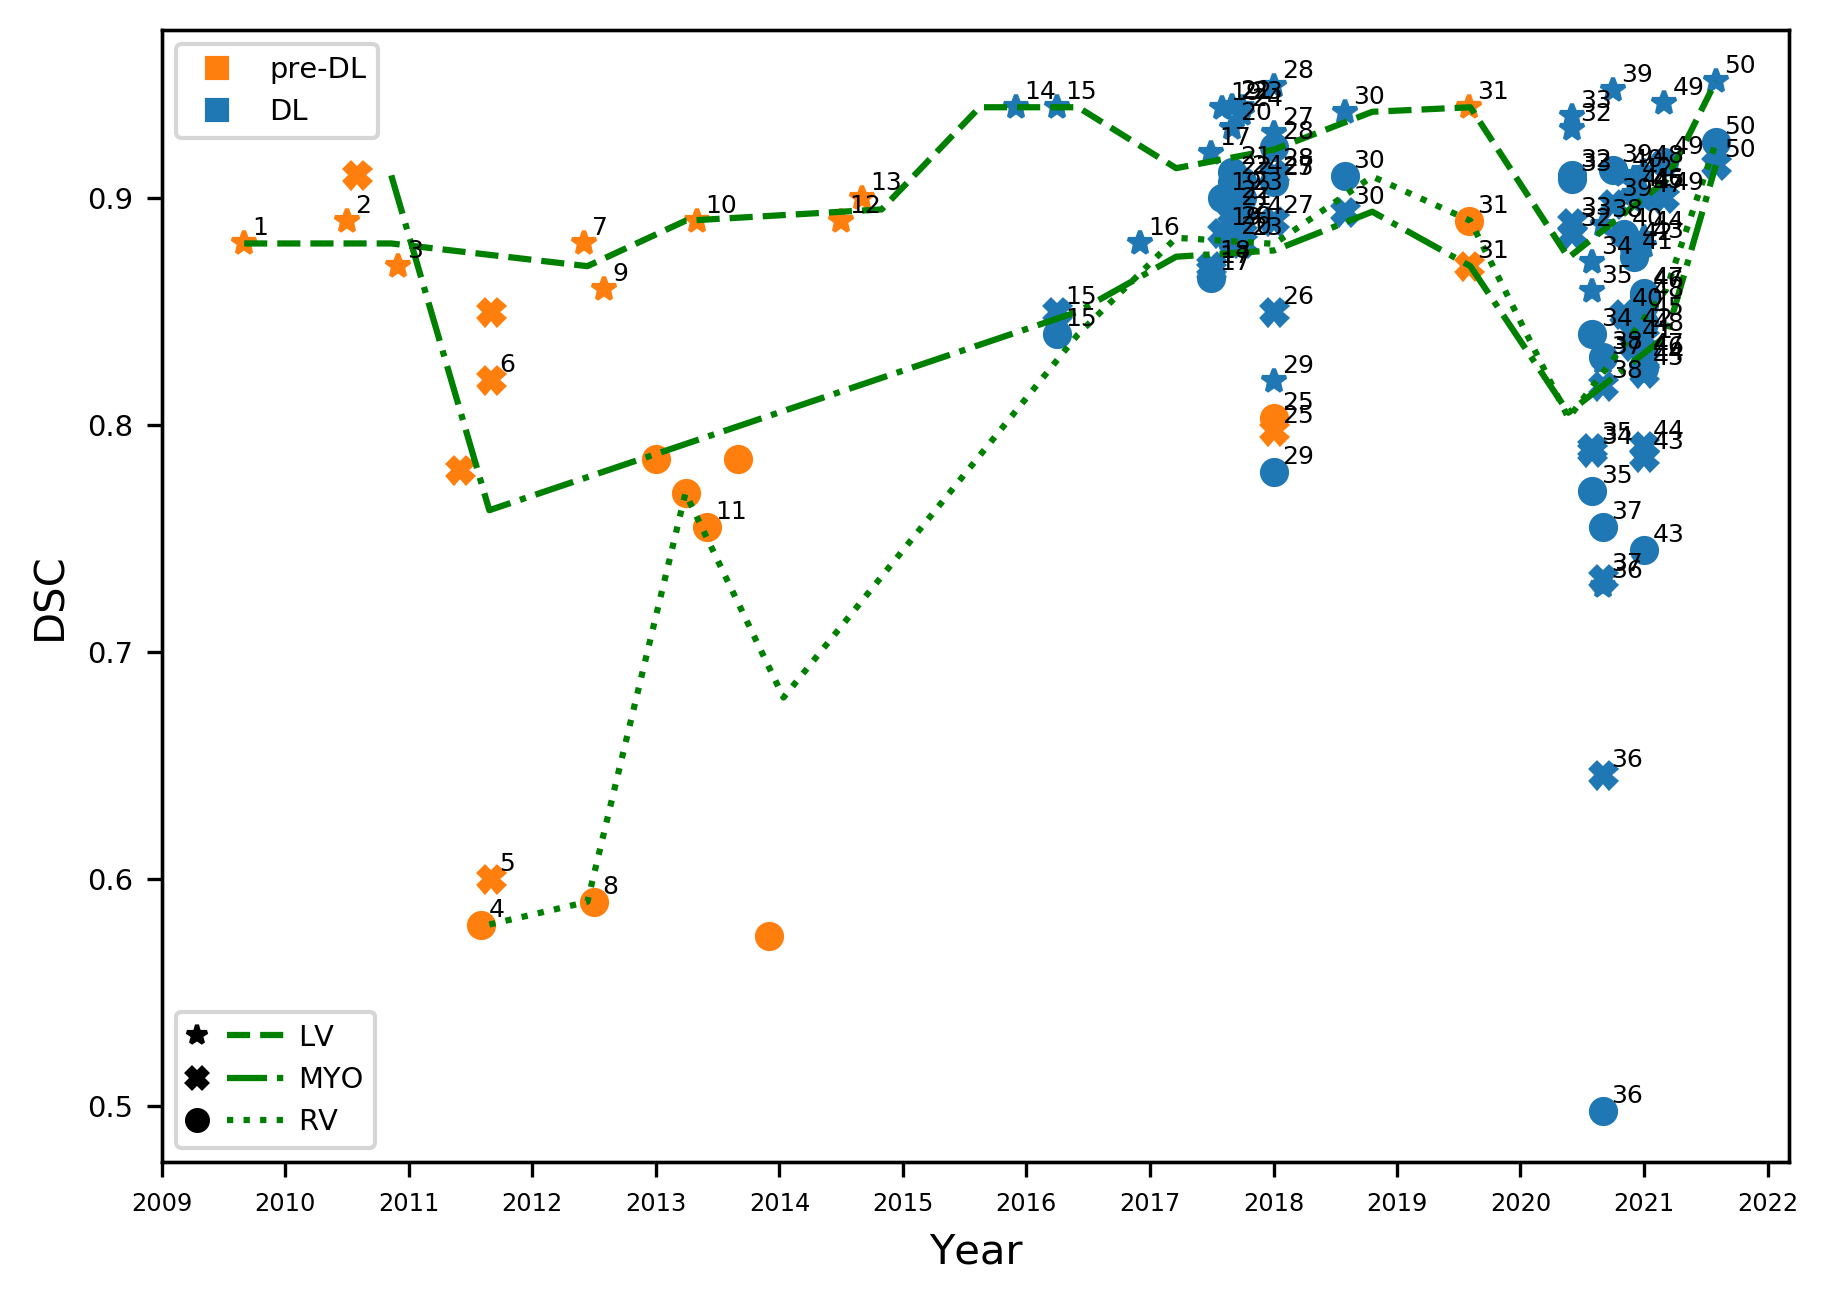

In [15]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

keys = ["Year", "LV DSC", "MYO DSC", "RV DSC", "DL", "Name"]
measures = df[keys].rename(
    columns={"Year": "date", "LV DSC": "lv", "MYO DSC": "myo", "RV DSC": "rv", "DL": "dl", "Name":"label"}
)

#measures = [AttrDict({"date": m[0], "lv": m[1], "myo": m[2], "rv": m[3], "dl": m[4], "label": m[5]}) for m in zip(dates, LV, MYO, RV, DL, names)]
measures = [AttrDict(dict(zip(measures.columns, row))) for row in measures.values]
measures.sort(key=lambda m: (m.date))

#0
graph(measures, title=None)

The window size is:  290 days, 3:12:00 15
The window size is:  290 days, 3:12:00 15
The window size is:  290 days, 3:12:00 15


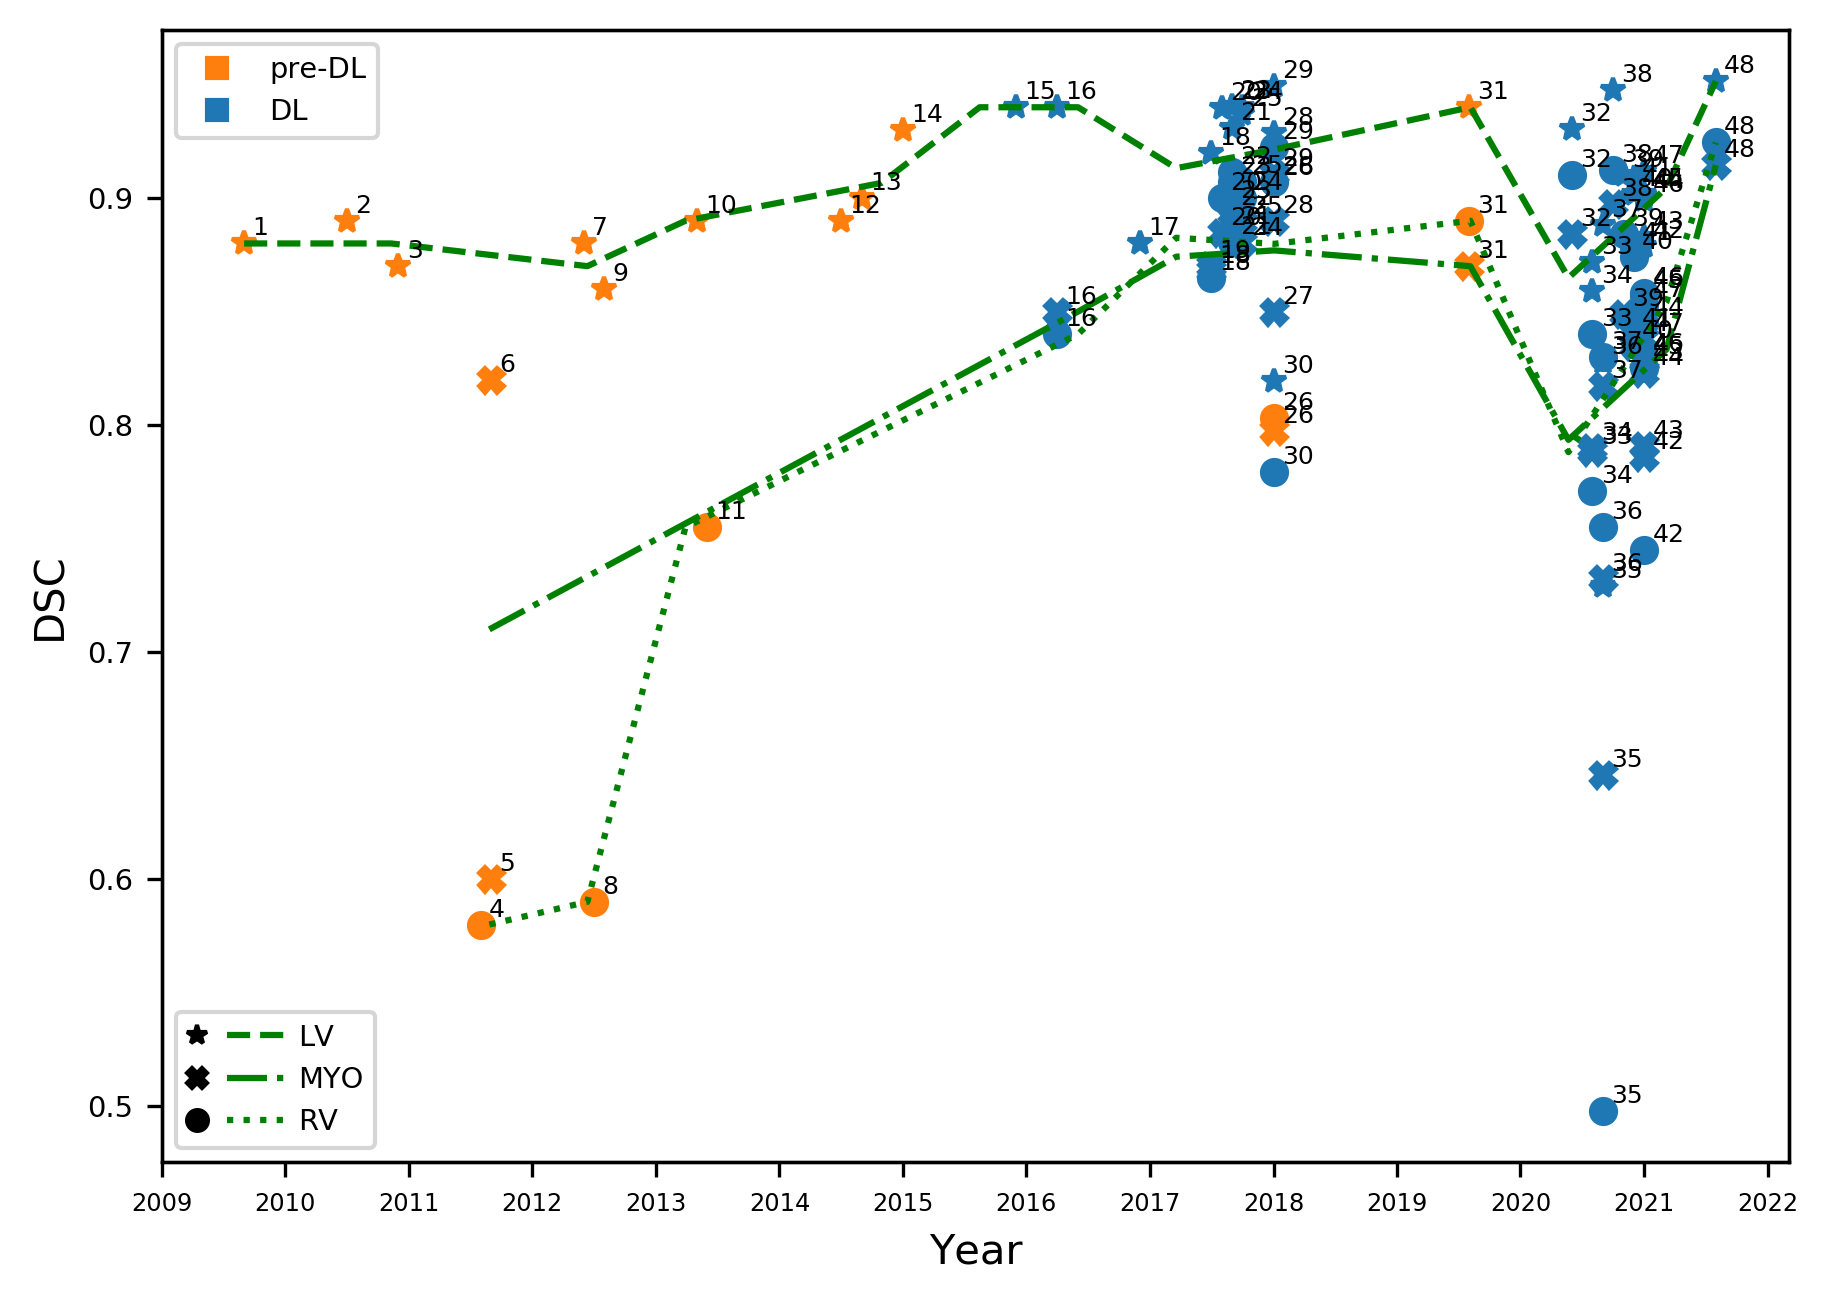

In [40]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

keys = ["Year", "LV DSC", "MYO DSC", "RV DSC", "DL", "Name"]
measures = df[df.FA == True][keys].rename(
    columns={"Year": "date", "LV DSC": "lv", "MYO DSC": "myo", "RV DSC": "rv", "DL": "dl", "Name":"label"}
)

#measures = [AttrDict({"date": m[0], "lv": m[1], "myo": m[2], "rv": m[3], "dl": m[4], "label": m[5]}) for m in zip(dates, LV, MYO, RV, DL, names)]
measures = [AttrDict(dict(zip(measures.columns, row))) for row in measures.values]
measures.sort(key=lambda m: (m.date))#, -m.rv))

#1/2
graph(measures, title=None)

The window size is:  290 days, 3:12:00 15
The window size is:  290 days, 3:12:00 15
The window size is:  290 days, 3:12:00 15


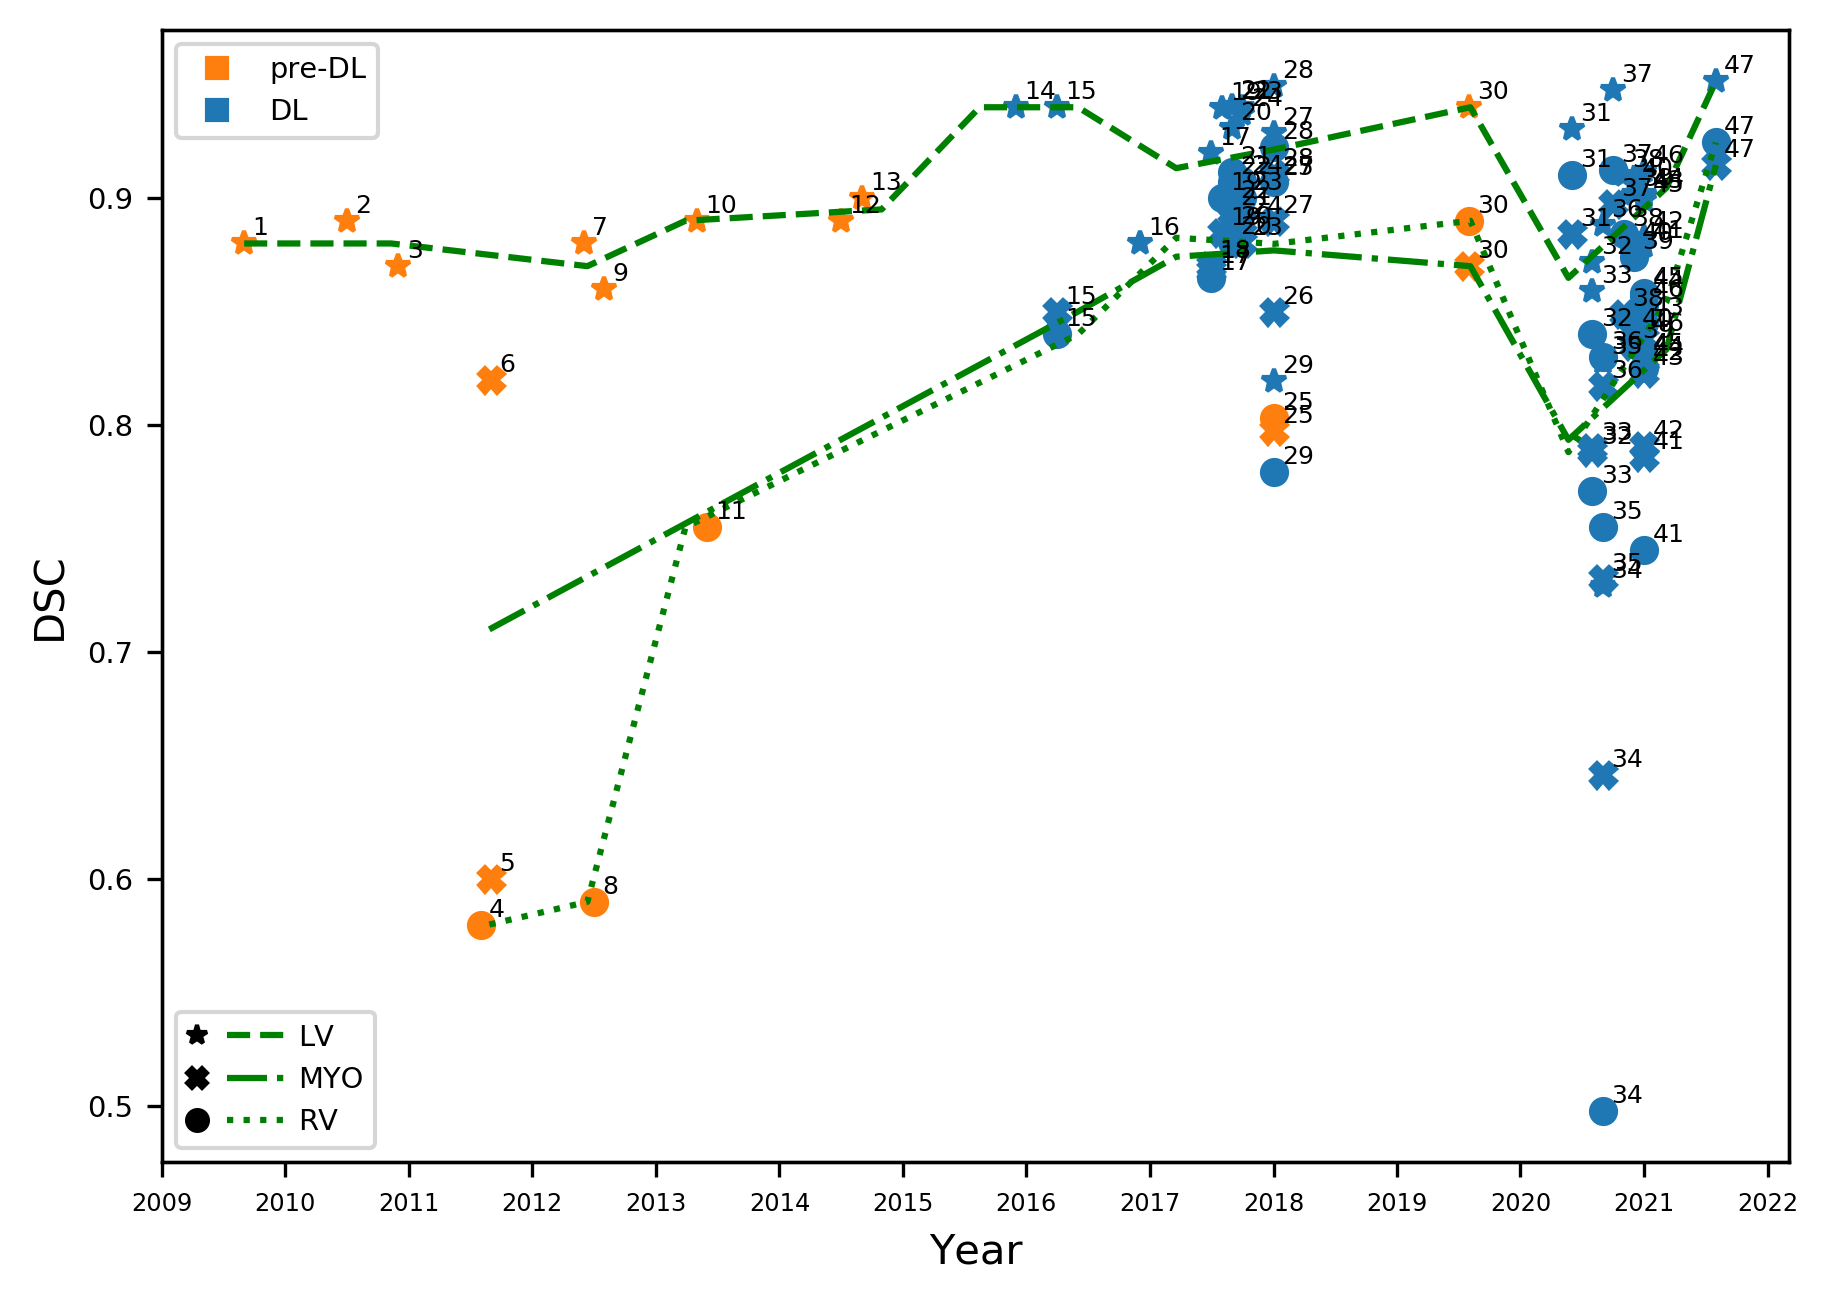

In [9]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

keys = ["Year", "LV DSC", "MYO DSC", "RV DSC", "DL", "Name"]
measures = df[df.FA == True][keys].rename(
    columns={"Year": "date", "LV DSC": "lv", "MYO DSC": "myo", "RV DSC": "rv", "DL": "dl", "Name":"label"}
)

#measures = [AttrDict({"date": m[0], "lv": m[1], "myo": m[2], "rv": m[3], "dl": m[4], "label": m[5]}) for m in zip(dates, LV, MYO, RV, DL, names)]
measures = [AttrDict(dict(zip(measures.columns, row))) for row in measures.values]
measures.sort(key=lambda m: (m.date))#, -m.rv))

#1/2
graph(measures, title=None)

In [25]:
before_dl={"lv": [], "myo": [], "rv": []}
after_dl={"lv": [], "myo": [], "rv": []}

for m in measures:
    if m.date.year <= 2015 and not m.dl:
        for structure in ["lv", "myo", "rv"]:
            if not np.isnan(m[structure]):
                before_dl[structure].append(m[structure])
    elif m.date.year >= 2015 and m.dl:
        for structure in ["lv", "myo", "rv"]:
            if not np.isnan(m[structure]):
                after_dl[structure].append(m[structure])

print(np.mean(before_dl["lv"]), np.mean(after_dl["lv"]))
print(np.mean(before_dl["myo"]), np.mean(after_dl["myo"]))
print(np.mean(before_dl["rv"]), np.mean(after_dl["rv"]))

0.8825000000000001 0.90565625
0.71 0.8470483870967742
0.6416666666666666 0.8538166666666666


In [16]:
nan_table = np.isnan(FA_table[["LV DSC", "MYO DSC", "RV DSC"]]).values
Structure = np.full(nan_table.shape, "str")
Structure[:, 0] = np.where(nan_table[:, 0], "", "LV")
Structure[:, 1] = np.where(nan_table[:, 1], "", "MYO")
Structure[:, 2] = np.where(nan_table[:, 2], "", "RV")
FA_table["Structure"] = [", ".join([j for j in i if j!=""]) for i in Structure]

In [105]:
missing = [
    """@article{Liu2012,
title = {Automatic Left Ventricle Segmentation in Cardiac MRI Using Topological Stable-State Thresholding and Region Restricted Dynamic Programming},
journal = {Academic Radiology},
volume = {19},
number = {6},
pages = {723-731},
year = {2012},
issn = {1076-6332},
doi = {https://doi.org/10.1016/j.acra.2012.02.011},
url = {https://www.sciencedirect.com/science/article/pii/S1076633212001006},
author = {Hong Liu and Huaifei Hu and Xiangyang Xu and Enmin Song},
keywords = {Cardiac MRI, left ventricle segmentation, topological stable-state thresholding, region restricted dynamic programming, non-maxima gradient suppression}
}""",
    """@article{Wang2012,
title={A simple and fully automatic right ventricle segmentation method for 4-dimensional cardiac MR images},
author={Wang, Ching-Wei and Peng, Chun-Wei and Chen, Hsiang-Chou},
journal={Proceedings of MICCAI RV segmentation challenge},
year={2012}
}""",
    """@article{Hu2013,
title = {Hybrid segmentation of left ventricle in cardiac MRI using gaussian-mixture model and region restricted dynamic programming},
journal = {Magnetic Resonance Imaging},
volume = {31},
number = {4},
pages = {575-584},
year = {2013},
issn = {0730-725X},
doi = {https://doi.org/10.1016/j.mri.2012.10.004},
url = {https://www.sciencedirect.com/science/article/pii/S0730725X12003670},
author = {Huaifei Hu and Haihua Liu and Zhiyong Gao and Lu Huang},
keywords = {Left ventricle segmentation, Gaussian-mixture model (GMM), Ray scanning, Non-maxima gradient suppression, Region restricted dynamic programming},
}""",
    """@INPROCEEDINGS{Tan2016,
author={Tan, Li Kuo and Liew, Yih Miin and Lim, Einly and McLaughlin, Robert A.},
booktitle={2016 IEEE EMBS Conference on Biomedical Engineering and Sciences (IECBES)}, 
title={Cardiac left ventricle segmentation using convolutional neural network regression}, 
year={2016},
volume={},
number={},
pages={490-493},
doi={10.1109/IECBES.2016.7843499}
}""",
    """@InProceedings{Grinias2018,
author="Grinias, Elias
and Tziritas, Georgios",
editor="Pop, Mihaela
and Sermesant, Maxime
and Jodoin, Pierre-Marc
and Lalande, Alain
and Zhuang, Xiahai
and Yang, Guang
and Young, Alistair
and Bernard, Olivier",
title="Fast Fully-Automatic Cardiac Segmentation in MRI Using MRF Model Optimization, Substructures Tracking and B-Spline Smoothing",
booktitle="Statistical Atlases and Computational Models of the Heart. ACDC and MMWHS Challenges",
year="2018",
publisher="Springer International Publishing",
address="Cham",
pages="91--100",
isbn="978-3-319-75541-0"
}""",
    """@article{Khened2018,
title = {Fully convolutional multi-scale residual DenseNets for cardiac segmentation and automated cardiac diagnosis using ensemble of classifiers},
journal = {Medical Image Analysis},
volume = {51},
pages = {21-45},
year = {2019},
issn = {1361-8415},
doi = {https://doi.org/10.1016/j.media.2018.10.004},
url = {https://www.sciencedirect.com/science/article/pii/S136184151830848X},
author = {Mahendra Khened and Varghese Alex Kollerathu and Ganapathy Krishnamurthi},
keywords = {Deep learning, Ensemble classifier, Cardiac MRI, Segmentation, Automated diagnosis, Fully convolutional densenets.},
}"""
]

miss_cnt = 0
for citation, link in FA_table[["Citation", "Link"]].values:
    if citation == "LOOK FOR IT":
        citation = missing[miss_cnt]
        miss_cnt += 1
    print(citation, end="\n\n")

@inproceedings{Jolly2009,
  author    = {Marie{-}Pierre Jolly and
               Hui Xue and
               Leo J. Grady and
               Jens Guehring},
  editor    = {Guang{-}Zhong Yang and
               David J. Hawkes and
               Daniel Rueckert and
               J. Alison Noble and
               Christopher J. Taylor},
  title     = {Combining Registration and Minimum Surfaces for the Segmentation of
               the Left Ventricle in Cardiac Cine {MR} Images},
  booktitle = {Medical Image Computing and Computer-Assisted Intervention - {MICCAI}
               2009, 12th International Conference, London, UK, September 20-24,
               2009, Proceedings, Part {II}},
  series    = {Lecture Notes in Computer Science},
  volume    = {5762},
  pages     = {910--918},
  publisher = {Springer},
  year      = {2009},
  url       = {https://doi.org/10.1007/978-3-642-04271-3\_110},
  doi       = {10.1007/978-3-642-04271-3\_110},
  timestamp = {Tue, 09 Nov 2021 18:19:01 +01

In [22]:
#1 & Author 1 & LV & 2 & Author 2 & LV\\
#3 & Author 3 & LV, RV, MYO & 4 & Author 4 & LV, RV, MYO\\

for i, row in enumerate(FA_table[["index", "Name", "Challenge", "Year"]].values):
    row[1]+="~\cite{"+row[1].split(" ")[0]+str(row[-1].year)+"}"
    print(*row[:-1], sep=" & ", end = "")
    if i % 2 == 0:
        print(" & ", end="")
    else:
        print("\\\\\n", end="")

1 & Jolly et al.~\cite{Jolly2009} & LV & 2 & Huang et al.~\cite{Huang2010} & LV\\
3 & Schaerer et al.~\cite{Schaerer2010} & LV & 4 & Ou et al.~\cite{Ou2011} & RV\\
5 & Margeta et al.~\cite{Margeta2011} & MYO & 6 & Jolly et al.~\cite{Jolly2011} & MYO\\
7 & Liu et al.~\cite{Liu2012} & LV & 8 & Wang et al.~\cite{Wang2012} & RV\\
9 & Constantinidès et al.~\cite{Constantinidès2012} & LV & 10 & Hu et al.~\cite{Hu2013} & LV\\
11 & Zuluaga et al.~\cite{Zuluaga2013} & RV & 12 & Ngo and Carneiro~\cite{Ngo2014} & LV\\
13 & Queirós et al.~\cite{Queirós2014} & LV & 14 & Avendi et al.~\cite{Avendi2015} & LV\\
15 & Tran Phi Vu~\cite{Tran2016} & LV/MYO/RV & 16 & Tan et al.~\cite{Tan2016} & LV\\
17 & Patravali et al.~\cite{Patravali2017} & ACDC & 18 & Tan et al.~\cite{Tan2017} & MYO\\
19 & Wolterink et al.~\cite{Wolterink2017} & ACDC & 20 & Rohé et al.~\cite{Rohé2017} & ACDC\\
21 & Zotti et al.~\cite{Zotti2017} & ACDC & 22 & Khened et al.~\cite{Khened2017} & ACDC\\
23 & Bai et al.~\cite{Bai2017} & UKBB

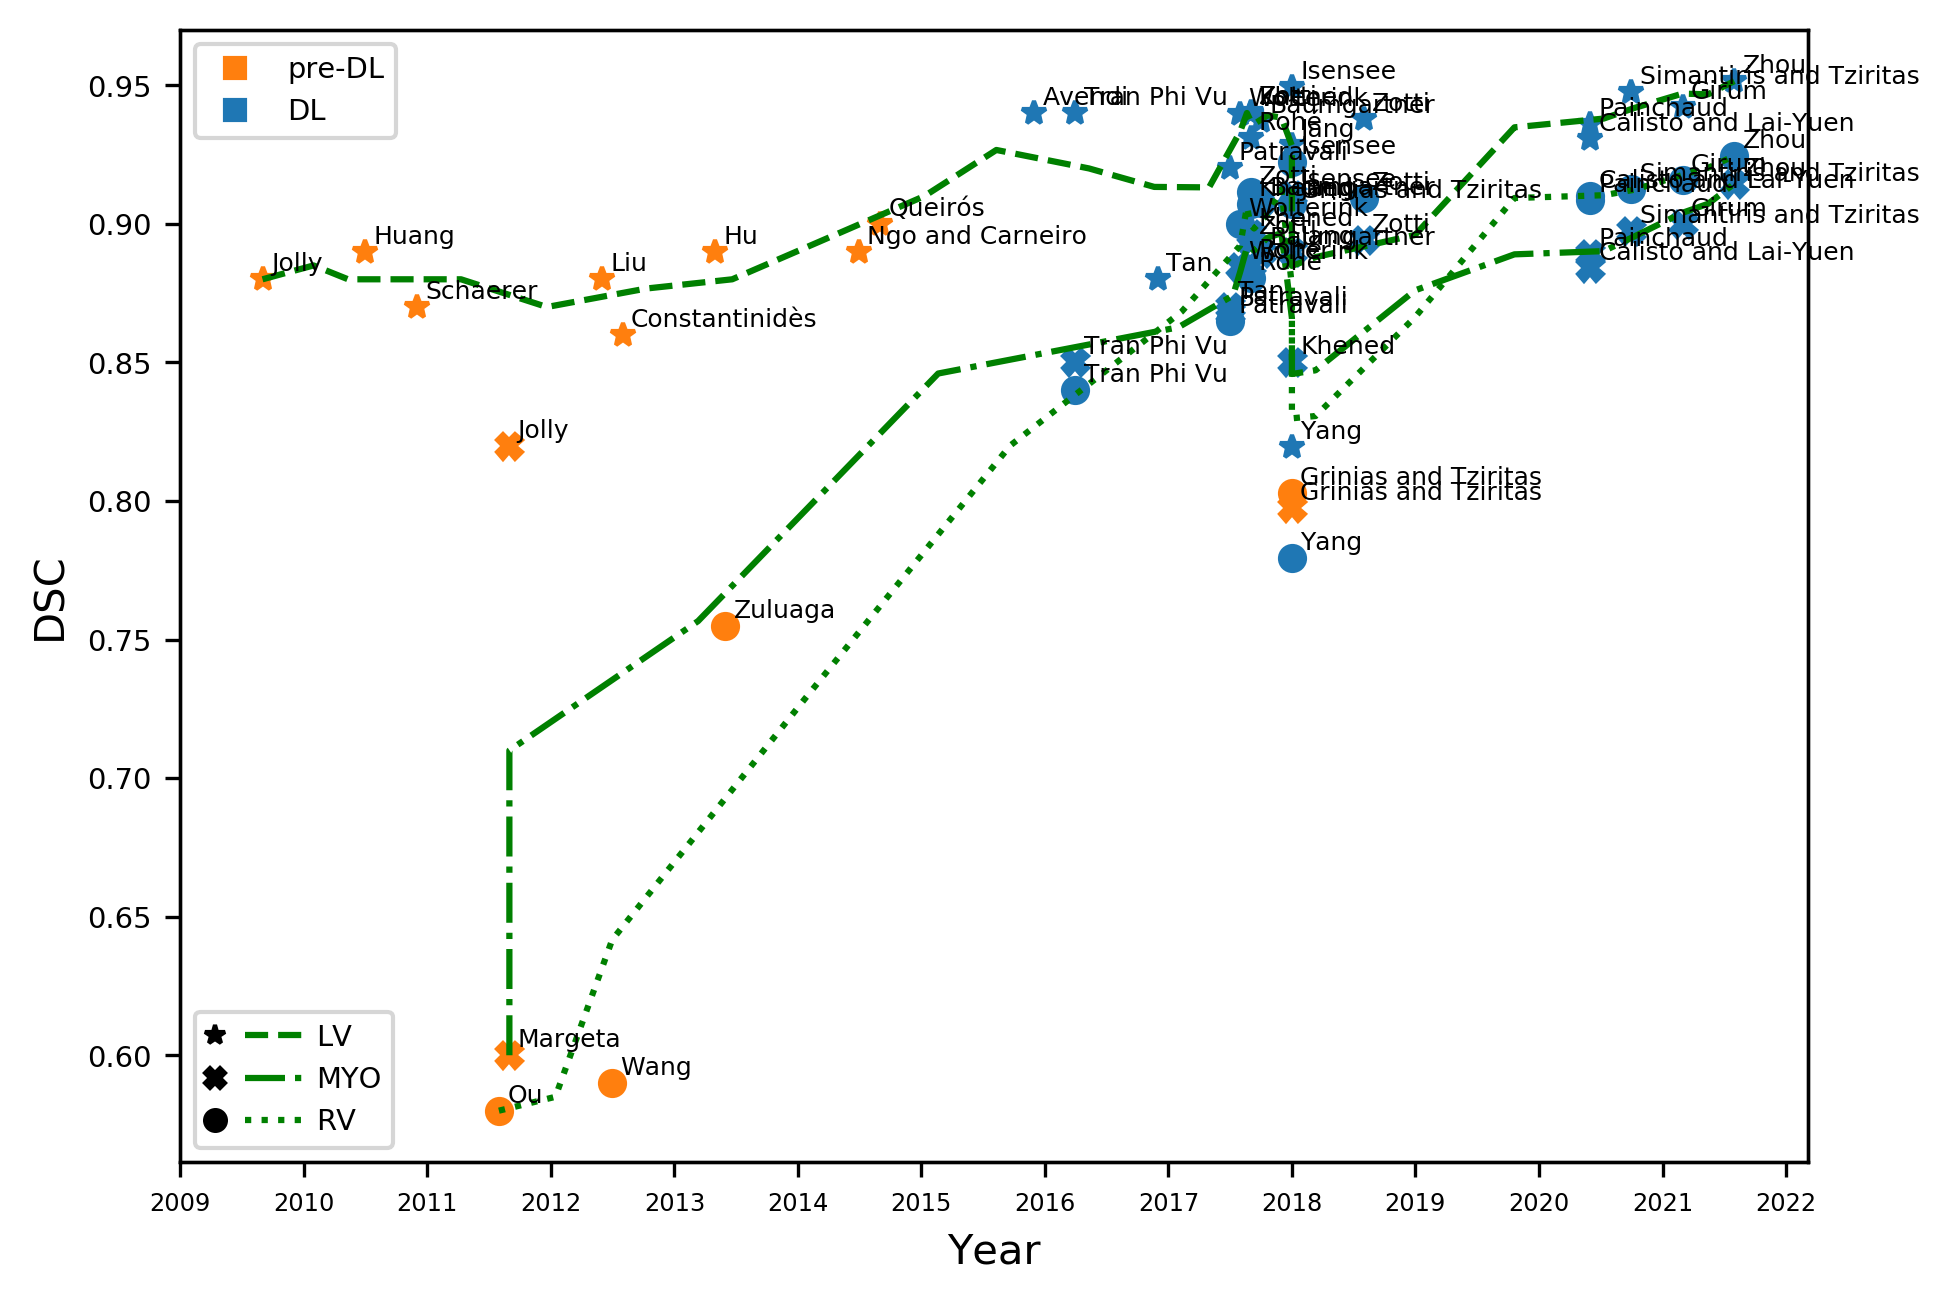

In [14]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

keys = ["Year", "LV DSC", "MYO DSC", "RV DSC", "DL", "Name"]
measures = df[
        (df["Challenge"] != "M&Ms") & (df.FA.map(lambda dl: bool(dl)) == True)
][keys].rename(columns={"Year": "date", "LV DSC": "lv", "MYO DSC": "myo", "RV DSC": "rv", "DL": "dl", "Name":"label"})

#measures = [AttrDict({"date": m[0], "lv": m[1], "myo": m[2], "rv": m[3], "dl": m[4], "label": m[5]}) for m in zip(dates, LV, MYO, RV, DL, names)]
measures = [AttrDict(dict(zip(measures.columns, row))) for row in measures.values]
measures.sort(key=lambda m: (m.date, -m.rv))

#3
graph(measures, title=None)

In [107]:
listona = ["@inproceedings{DBLP:conf/miccai/ZhangGF17,\r\n  author    = {Le Zhang and\r\n               Ali Gooya and\r\n               Alejandro F. Frangi},\r\n  editor    = {Sotirios A. Tsaftaris and\r\n               Ali Gooya and\r\n               Alejandro F. Frangi and\r\n               Jerry L. Prince},\r\n  title     = {Semi-supervised Assessment of Incomplete {LV} Coverage in Cardiac\r\n               {MRI} Using Generative Adversarial Nets},\r\n  booktitle = {Simulation and Synthesis in Medical Imaging - Second International\r\n               Workshop, {SASHIMI} 2017, Held in Conjunction with {MICCAI} 2017,\r\n               Qu{\\'{e}}bec City, QC, Canada, September 10, 2017, Proceedings},\r\n  series    = {Lecture Notes in Computer Science},\r\n  volume    = {10557},\r\n  pages     = {61--68},\r\n  publisher = {Springer},\r\n  year      = {2017},\r\n  url       = {https://doi.org/10.1007/978-3-319-68127-6\\_7},\r\n  doi       = {10.1007/978-3-319-68127-6\\_7},\r\n  timestamp = {Thu, 10 Oct 2019 13:06:30 +0200},\r\n  biburl    = {https://dblp.org/rec/conf/miccai/ZhangGF17.bib},\r\n  bibsource = {dblp computer science bibliography, https://dblp.org}\r\n}", "@inproceedings{DBLP:conf/miccai/SchlemperOBCDQH18,\r\n  author    = {Jo Schlemper and\r\n               Ozan Oktay and\r\n               Wenjia Bai and\r\n               Daniel Coelho de Castro and\r\n               Jinming Duan and\r\n               Chen Qin and\r\n               Joseph V. Hajnal and\r\n               Daniel Rueckert},\r\n  editor    = {Alejandro F. Frangi and\r\n               Julia A. Schnabel and\r\n               Christos Davatzikos and\r\n               Carlos Alberola{-}L{\\'{o}}pez and\r\n               Gabor Fichtinger},\r\n  title     = {Cardiac {MR} Segmentation from Undersampled k-space Using Deep Latent\r\n               Representation Learning},\r\n  booktitle = {Medical Image Computing and Computer Assisted Intervention - {MICCAI}\r\n               2018 - 21st International Conference, Granada, Spain, September 16-20,\r\n               2018, Proceedings, Part {I}},\r\n  series    = {Lecture Notes in Computer Science},\r\n  volume    = {11070},\r\n  pages     = {259--267},\r\n  publisher = {Springer},\r\n  year      = {2018},\r\n  url       = {https://doi.org/10.1007/978-3-030-00928-1\\_30},\r\n  doi       = {10.1007/978-3-030-00928-1\\_30},\r\n  timestamp = {Thu, 14 Oct 2021 10:35:04 +0200},\r\n  biburl    = {https://dblp.org/rec/conf/miccai/SchlemperOBCDQH18.bib},\r\n  bibsource = {dblp computer science bibliography, https://dblp.org}\r\n}", '@article{DBLP:journals/mia/OksuzRPCCBPBRSK19,\r\n  author    = {Ilkay {\\"{O}}ks{\\"{u}}z and\r\n               Bram Ruijsink and\r\n               Esther Puyol{-}Ant{\\\'{o}}n and\r\n               James R. Clough and\r\n               Gast{\\~{a}}o Cruz and\r\n               Aur{\\\'{e}}lien Bustin and\r\n               Claudia Prieto and\r\n               Ren{\\\'{e}} M. Botnar and\r\n               Daniel Rueckert and\r\n               Julia A. Schnabel and\r\n               Andrew P. King},\r\n  title     = {Automatic CNN-based detection of cardiac {MR} motion artefacts using\r\n               k-space data augmentation and curriculum learning},\r\n  journal   = {Medical Image Anal.},\r\n  volume    = {55},\r\n  pages     = {136--147},\r\n  year      = {2019},\r\n  url       = {https://doi.org/10.1016/j.media.2019.04.009},\r\n  doi       = {10.1016/j.media.2019.04.009},\r\n  timestamp = {Mon, 03 Jan 2022 22:08:13 +0100},\r\n  biburl    = {https://dblp.org/rec/journals/mia/OksuzRPCCBPBRSK19.bib},\r\n  bibsource = {dblp computer science bibliography, https://dblp.org}\r\n}', 'LOOK FOR IT', 'LOOK FOR IT', "@inproceedings{DBLP:conf/fimh/Huang0YAM19,\r\n  author    = {Qiaoying Huang and\r\n               Dong Yang and\r\n               Jingru Yi and\r\n               Leon Axel and\r\n               Dimitris N. Metaxas},\r\n  editor    = {Yves Coudi{\\`{e}}re and\r\n               Val{\\'{e}}ry Ozenne and\r\n               Edward J. Vigmond and\r\n               Nejib Zemzemi},\r\n  title     = {FR-Net: Joint Reconstruction and Segmentation in Compressed Sensing\r\n               Cardiac {MRI}},\r\n  booktitle = {Functional Imaging and Modeling of the Heart - 10th International\r\n               Conference, {FIMH} 2019, Bordeaux, France, June 6-8, 2019, Proceedings},\r\n  series    = {Lecture Notes in Computer Science},\r\n  volume    = {11504},\r\n  pages     = {352--360},\r\n  publisher = {Springer},\r\n  year      = {2019},\r\n  url       = {https://doi.org/10.1007/978-3-030-21949-9\\_38},\r\n  doi       = {10.1007/978-3-030-21949-9\\_38},\r\n  timestamp = {Fri, 31 May 2019 10:27:51 +0200},\r\n  biburl    = {https://dblp.org/rec/conf/fimh/Huang0YAM19.bib},\r\n  bibsource = {dblp computer science bibliography, https://dblp.org}\r\n}"]

for x in listona:
    print(x)

@inproceedings{DBLP:conf/miccai/ZhangGF17,
  author    = {Le Zhang and
               Ali Gooya and
               Alejandro F. Frangi},
  editor    = {Sotirios A. Tsaftaris and
               Ali Gooya and
               Alejandro F. Frangi and
               Jerry L. Prince},
  title     = {Semi-supervised Assessment of Incomplete {LV} Coverage in Cardiac
               {MRI} Using Generative Adversarial Nets},
  booktitle = {Simulation and Synthesis in Medical Imaging - Second International
               Workshop, {SASHIMI} 2017, Held in Conjunction with {MICCAI} 2017,
               Qu{\'{e}}bec City, QC, Canada, September 10, 2017, Proceedings},
  series    = {Lecture Notes in Computer Science},
  volume    = {10557},
  pages     = {61--68},
  publisher = {Springer},
  year      = {2017},
  url       = {https://doi.org/10.1007/978-3-319-68127-6\_7},
  doi       = {10.1007/978-3-319-68127-6\_7},
  timestamp = {Thu, 10 Oct 2019 13:06:30 +0200},
  biburl    = {https://dblp.org/rec/c

## Barplot

In [98]:
import pandas as pd
from datetime import date

df = pd.read_excel("scores.xlsx").tail(37).head(28)

df["Year"] = df["Year"].map(lambda d: d.date())
df["DL"] = df["DL"].map(lambda dl: bool(dl))
df["FA"] = df["FA"].map(lambda fa: bool(fa))
df["MI"] = df["MI"].map(lambda fa: bool(fa))
df["Name"] = df["Name"].map(lambda name: name.split("/")[-1].replace("(expert guided)", ""))
df["Link"] = df["Link"].map(lambda link: link.replace("www.", ""))

In [99]:
import numpy as np

nonMI_values = np.array(df[~df.MI][["LV DSC", "MYO DSC", "RV DSC"]]).reshape(-1)
MI_values = np.array(df[df.MI][["LV DSC", "MYO DSC", "RV DSC"]]).reshape(-1)

nonMI_HD = np.array(df[~df.MI][["LV HD", "MYO HD", "RV HD"]]).reshape(-1)
MI_HD = np.array(df[df.MI][["LV HD", "MYO HD", "RV HD"]]).reshape(-1)

In [3]:
nonMI_values = [v for v in nonMI_values if not np.isnan(v)]
MI_values = [v for v in MI_values if not np.isnan(v)]

nonMI_HD = [v for v in nonMI_HD if not np.isnan(v)]
MI_HD = [v for v in MI_HD if not np.isnan(v)]

In [ ]:
#OLD
# libraries
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["legend.fontsize"] = u"xx-large"
plt.rcParams["xtick.labelsize"] = u"xx-large"
plt.rcParams["ytick.labelsize"] = u"xx-large"
plt.rcParams["axes.labelsize"] = 20

# width of the bars
barWidth = 0.23
 
# Choose the height of the blue bars
bars1 = [np.mean(nonMI_values), np.mean(MI_values)]
bars2 = [np.mean(nonMI_HD), np.mean(MI_HD)]
 
# Choose the height of the error bars (bars1)
yer1 = [np.std(nonMI_values), np.std(MI_values)]
yer2 = [np.std(nonMI_HD), np.std(MI_HD)]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
fig, ax1 = plt.subplots(figsize=(11,8))
ax1.set_ylabel('DSC', color="#ff7f0e")
ax1.bar(r1, bars1, width = barWidth, color = '#ff7f0e', edgecolor = 'black', yerr=yer1, capsize=7, label='DSC')

ax2 = ax1.twinx()
ax2.set_ylabel('HD', color="#1f77b4")
ax2.bar(r2, bars2, width = barWidth, color = '#1f77b4', edgecolor = 'black', yerr=yer2, capsize=7, label='HD')
 
# general layout
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['Without Improvement', 'With Improvement'])
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=0)
 
# Show graphic
plt.show()

In [195]:
DSCs = df[["LV DSC", "MYO DSC", "RV DSC"]].values.reshape(-1)
HDs = df[["LV HD", "MYO HD", "RV HD"]].values.reshape(-1)


dataDSCs=pd.DataFrame.from_dict({
    "DSC": DSCs.tolist() + (np.mean(DSCs) + 0*HDs).tolist(),
    "isHD": [False] * len(df) * 3 + [True] * len(df) * 3,
    "MI": ["w/ MI" if x else "w/o MI" for x in df[["MI", "MI", "MI"]].values.reshape(-1).tolist() * 2],
})

dataHDs=pd.DataFrame.from_dict({
    "HD": (np.mean(HDs) + 0*DSCs).tolist() + HDs.tolist(),
    "isHD": [False] * len(df) * 3 + [True] * len(df) * 3,
    "MI": ["w/ MI" if x else "w/o MI" for x in df[["MI", "MI", "MI"]].values.reshape(-1).tolist() * 2],
})

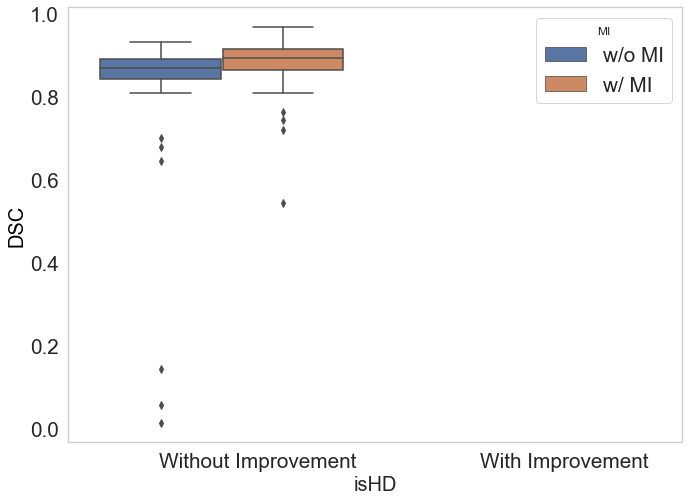

In [198]:
# libraries
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["legend.fontsize"] = u"xx-large"
plt.rcParams["xtick.labelsize"] = u"xx-large"
plt.rcParams["ytick.labelsize"] = u"xx-large"
plt.rcParams["axes.labelsize"] = 20

# width of the bars
barWidth = 0.23
 
# Choose the height of the blue bars
bars1 = [np.mean(nonMI_values), np.mean(MI_values)]
bars2 = [np.mean(nonMI_HD), np.mean(MI_HD)]
 
# Choose the height of the error bars (bars1)
yer1 = [np.std(nonMI_values), np.std(MI_values)]
yer2 = [np.std(nonMI_HD), np.std(MI_HD)]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
fig, ax1 = plt.subplots(figsize=(11,8))
ax1.set_ylabel('DSC', color="#000000")
#ax1.bar(r1, bars1, width = barWidth, color = '#ff7f0e', edgecolor = 'black', yerr=yer1, capsize=7, label='DSC')
sns.boxplot(x="isHD", y="DSC", hue="MI", data=dataDSCs, ax=ax1)
ax1.grid(False)

 
# general layout
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['Without Improvement', 'With Improvement'])
h1, l1 = ax1.get_legend_handles_labels()
 
# Show graphic
plt.show()

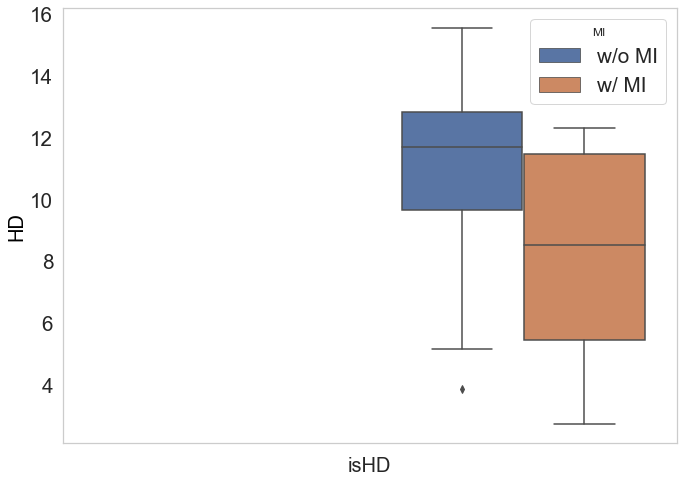

In [199]:
# libraries
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["legend.fontsize"] = u"xx-large"
plt.rcParams["xtick.labelsize"] = u"xx-large"
plt.rcParams["ytick.labelsize"] = u"xx-large"
plt.rcParams["axes.labelsize"] = 20

# width of the bars
barWidth = 0.23
 
# Choose the height of the blue bars
bars1 = [np.mean(nonMI_values), np.mean(MI_values)]
bars2 = [np.mean(nonMI_HD), np.mean(MI_HD)]
 
# Choose the height of the error bars (bars1)
yer1 = [np.std(nonMI_values), np.std(MI_values)]
yer2 = [np.std(nonMI_HD), np.std(MI_HD)]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
fig, ax1 = plt.subplots(figsize=(11,8))
ax1.set_ylabel('DSC', color="#000000")
#ax1.bar(r1, bars1, width = barWidth, color = '#ff7f0e', edgecolor = 'black', yerr=yer1, capsize=7, label='DSC')
sns.boxplot(x="isHD", y="HD", hue="MI", data=dataHDs, ax=ax1)
ax1.grid(False)

# general layout
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['', ''])
h1, l1 = ax1.get_legend_handles_labels()
 
# Show graphic
plt.show()

In [42]:
text = """1 & Jolly et al.~\cite{Jolly2009} & LV & 2 & Huang et al.~\cite{Huang2010} & LV\\
3 & Schaerer et al.~\cite{Schaerer2010} & LV & 4 & Ou et al.~\cite{Ou2011} & RV\\
5 & Margeta et al.~\cite{Margeta2011} & MYO & 6 & Jolly et al.~\cite{Jolly2011} & MYO\\
7 & Liu et al.~\cite{Liu2012} & LV & 8 & Wang et al.~\cite{Wang2012} & RV\\
9 & Constantinidès et al.~\cite{Constantinides2012} & LV & 10 & Hu et al.~\cite{Hu2013} & LV\\
11 & Zuluaga et al.~\cite{Zuluaga2013} & RV & 12 & Ngo and Carneiro~\cite{Ngo2014} & LV\\
13 & Queirós et al.~\cite{Queiros2014} & LV & 14 & Avendi et al.~\cite{Avendi2015} & LV\\
15 & Tran Phi Vu~\cite{Tran2016} & ALL & 16 & Tan et al.~\cite{Tan2016} & LV\\
17 & Patravali et al.~\cite{Patravali2017} & ALL & 18 & Tan et al.~\cite{Tan2017} & MYO\\
19 & Wolterink et al.~\cite{Wolterink2017} & ALL & 20 & Rohé et al.~\cite{Rohe2017} & ALL\\
21 & Zotti et al.~\cite{Zotti2018} & ALL & 22 & Khened et al.~\cite{Khened2017} & ALL\\
23 & Bai et al.~\cite{bai2018} & ALL & 24 & Baumgartner et al.~\cite{Baumgartner2017} & ALL\\
25 & Grinias and Tziritas~\cite{Grinias2018} & ALL & 26 & Khened et al.~\cite{Khened2018} & MYO\\
27 & Jang et al.~\cite{Jang2018} & ALL & 28 & Isensee et al.~\cite{Isensee2018} & ALL\\
29 & Yang et al.~\cite{Yang2018} & ALL & 30 & Attar et al.~\cite{Attar2019} & ALL\\
31 & Calisto and Lai-Yuen~\cite{Calisto2020} & ALL & 32 & Scannell et al.~\cite{Scannell2020} & ALL\\
33 & Liu et al.~\cite{Liu2020} & ALL & 34 & Li et al.~\cite{Li2020} & ALL\\
35 & Huang et al.~\cite{Huang2020} & ALL & 36 & Li et al.~\cite{Li2020_2} & ALL\\
37 & Simantiris and Tziritas~\cite{Simantiris2020} & ALL & 38 & Full et al.~\cite{Full2020} & ALL\\
39 & Ma~\cite{Ma2020} & ALL & 42 & Zhang et al.~\cite{Zhang2020} & ALL\\
41 & Carscadden et al.~\cite{Carscadden2021} & ALL & 42 & Khader et al.~\cite{Khader2021} & ALL\\
43 & Saber et al.~\cite{Saber2021} & ALL & 44 & Kong and Shadden~\cite{Kong2021} & ALL\\
45 & Acero et al.~\cite{Acero2021} & ALL & 46 & Parreño et al.~\cite{Parreno2021} & ALL\\
47 & Zhou et al.~\cite{Zhou2021} & ALL\\"""

lines = [line for line in text.split("\n")]

lines = ["&".join([" {} ".format(i+1 if j==0 else i+25) if j in [0, 3] else col for j, col in enumerate(line.split("&"))]) for i, line in enumerate(lines)]

for line in lines:
    print(line+"\\")

 1 & Jolly et al.~\cite{Jolly2009} & LV & 25 & Huang et al.~\cite{Huang2010} & LV\\
 2 & Schaerer et al.~\cite{Schaerer2010} & LV & 26 & Ou et al.~\cite{Ou2011} & RV\\
 3 & Margeta et al.~\cite{Margeta2011} & MYO & 27 & Jolly et al.~\cite{Jolly2011} & MYO\\
 4 & Liu et al.~\cite{Liu2012} & LV & 28 & Wang et al.~\cite{Wang2012} & RV\\
 5 & Constantinidès et al.~\cite{Constantinides2012} & LV & 29 & Hu et al.~\cite{Hu2013} & LV\\
 6 & Zuluaga et al.~\cite{Zuluaga2013} & RV & 30 & Ngo and Carneiro~\cite{Ngo2014} & LV\\
 7 & Queirós et al.~\cite{Queiros2014} & LV & 31 & Avendi et al.~\cite{Avendi2015} & LV\\
 8 & Tran Phi Vu~\cite{Tran2016} & ALL & 32 & Tan et al.~\cite{Tan2016} & LV\\
 9 & Patravali et al.~\cite{Patravali2017} & ALL & 33 & Tan et al.~\cite{Tan2017} & MYO\\
 10 & Wolterink et al.~\cite{Wolterink2017} & ALL & 34 & Rohé et al.~\cite{Rohe2017} & ALL\\
 11 & Zotti et al.~\cite{Zotti2018} & ALL & 35 & Khened et al.~\cite{Khened2017} & ALL\\
 12 & Bai et al.~\cite{bai2018} & ALL

In [53]:
lines = [line for line in text.split("\n")]

lines = [["&".join(line.split("&")[:3])[:-1], "&".join(line.split("&")[3:])[1:-1]] for line in lines]

lines = [row for line in lines for row in line][:-1]

lines = [str(int(line[:2])+1) + line[2:] if int(line[:2]) >= 14 else line for line in lines]
lines = lines[:13] + [""] + lines[13:]

table = ""
for i in range(len(lines)//2):
    table += lines[i] + " & " + lines[i + len(lines)//2] + "\\\\\n"

#table += lines[23] + "\\\\"
print(table)

1 & Jolly et al.~\cite{Jolly2009} & LV & 25 & Baumgartner et al.~\cite{Baumgartner2017} & ALL\\
2 & Huang et al.~\cite{Huang2010} & LV & 26 & Grinias and Tziritas~\cite{Grinias2018} & ALL\\
3 & Schaerer et al.~\cite{Schaerer2010} & LV & 27 & Khened et al.~\cite{Khened2018} & MYO\\
4 & Ou et al.~\cite{Ou2011} & RV & 28 & Jang et al.~\cite{Jang2018} & ALL\\
5 & Margeta et al.~\cite{Margeta2011} & MYO & 29 & Isensee et al.~\cite{Isensee2018} & ALL\\
6 & Jolly et al.~\cite{Jolly2011} & MYO & 30 & Yang et al.~\cite{Yang2018} & ALL\\
7 & Liu et al.~\cite{Liu2012} & LV & 31 & Attar et al.~\cite{Attar2019} & ALL\\
8 & Wang et al.~\cite{Wang2012} & RV & 32 & Calisto and Lai-Yuen~\cite{Calisto2020} & ALL\\
9 & Constantinidès et al.~\cite{Constantinides2012} & LV & 33 & Scannell et al.~\cite{Scannell2020} & ALL\\
10 & Hu et al.~\cite{Hu2013} & LV & 34 & Liu et al.~\cite{Liu2020} & ALL\\
11 & Zuluaga et al.~\cite{Zuluaga2013} & RV & 35 & Li et al.~\cite{Li2020} & ALL\\
12 & Ngo and Carneiro~\cite{